### Команда "Страховщики":

- Мартынов Дмитрий
- Осипов Роман
- Иванков Дмитрий
- Плахотин Андрей
- Максим Макаров
- Тайсумова Луиза

# Кейс 10 - Бинарная классификация перекрёстных продаж страхования

- [1. Общая информация о данных](#first)
- [2. Анализ целевой переменной](#second)
- [3. Анализ категориальных признаков](#third)
  - [3.1 Бинарные признаки](#third-one)
  - [3.2 Порядковые признаки](#third-two)
  - [3.3 Высококардинальные категориальные признаки](#third-three)
- [4. Анализ числовых признаков](#fource)
- [5. Корреляционный анализ по числовым признакам](#fifth)
- [6. Модели](#sixth)

In [1]:
!pip install -q "scikit-learn==1.7.2"
!pip install -q numpy pandas matplotlib seaborn
!pip install -q lightgbm catboost optuna
!pip install -q phik tabulate joblib category-encoders requests

In [2]:
# Основные библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import os
import requests
from io import BytesIO
import warnings
warnings.filterwarnings("ignore")

# Машинное обучение - scikit-learn
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    HalvingGridSearchCV
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, average_precision_score, ConfusionMatrixDisplay
)

# Дополнительные ML библиотеки
import lightgbm as lgb
from catboost import CatBoostClassifier
import joblib
from tabulate import tabulate

# Специальные библиотеки
import phik
from phik.report import plot_correlation_matrix
import optuna
from optuna.samplers import TPESampler
from category_encoders import CountEncoder

# Настройки отображения
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
sns.set_style("whitegrid")

In [3]:
FILE_PATH = 'https://media.githubusercontent.com/media/taysumova/urfu_ml/refs/heads/main/data_sources/train.csv'
MODELS_BASE_PATH = 'https://media.githubusercontent.com/media/taysumova/urfu_ml/refs/heads/main/models/'

<a id="first"></a>
## 1. Общая информация о данных

* id - порядковый номер
* Gender - пол
* Age - возраст
* Driving_License - наличие ВУ
* Region_Code - код региона
* Previously_Insured - застраховано ли ранее ТС
* Vehicle_Age - возраст ТС
* Vehicle_Damage - происходили ли ранее ДТП
* Annual_Premium - страховая премия
* Policy_Sales_Channel - идентификатор продавца
* Vintage - количество дней страхования в компании
* Response - ответил ли страхователь на предложение


In [4]:
df = pd.read_csv(FILE_PATH, index_col='id')

df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.00,0,1-2 Year,Yes,"65,101.00",124.00,187,0
1,Male,43,1,28.00,0,> 2 Years,Yes,"58,911.00",26.00,288,1
2,Female,25,1,14.00,1,< 1 Year,No,"38,043.00",152.00,254,0
3,Female,35,1,1.00,0,1-2 Year,Yes,"2,630.00",156.00,76,0
4,Female,36,1,15.00,1,1-2 Year,No,"31,951.00",152.00,294,0


In [5]:
df.shape

(11504798, 11)

**Вывод:**
- 11 504 798 - строк
- 11 - столбцов

In [6]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Non-Null Count     Dtype  
---  ------                --------------     -----  
 0   Gender                11504798 non-null  object 
 1   Age                   11504798 non-null  int64  
 2   Driving_License       11504798 non-null  int64  
 3   Region_Code           11504798 non-null  float64
 4   Previously_Insured    11504798 non-null  int64  
 5   Vehicle_Age           11504798 non-null  object 
 6   Vehicle_Damage        11504798 non-null  object 
 7   Annual_Premium        11504798 non-null  float64
 8   Policy_Sales_Channel  11504798 non-null  float64
 9   Vintage               11504798 non-null  int64  
 10  Response              11504798 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.0+ GB


In [7]:
df.isnull().sum() # проверка пропусков

,0
Gender,0
Age,0
Driving_License,0
Region_Code,0
Previously_Insured,0
Vehicle_Age,0
Vehicle_Damage,0
Annual_Premium,0
Policy_Sales_Channel,0
Vintage,0


In [8]:
df.duplicated().sum() # проверка на дубликаты

np.int64(0)

**Вывод:**
- 3 object
- 5 int64
- 3 float64
- Пропуски отсутствуют
- Дубликаты отсутствуют

### Разделение на категории

In [9]:
num_columns    = ["Age", "Annual_Premium", "Vintage"] # числовые
cat_colums     = ["Region_Code", "Vehicle_Age", "Policy_Sales_Channel"] # категориальные
binary_columns = ["Gender", "Driving_License", "Previously_Insured", "Vehicle_Damage", "Response"] # категориальные-бинарные

**Вывод:**

- 3 числовых
- 8 категориальных

<a id="second"></a>
## 2. Анализ целевой переменной

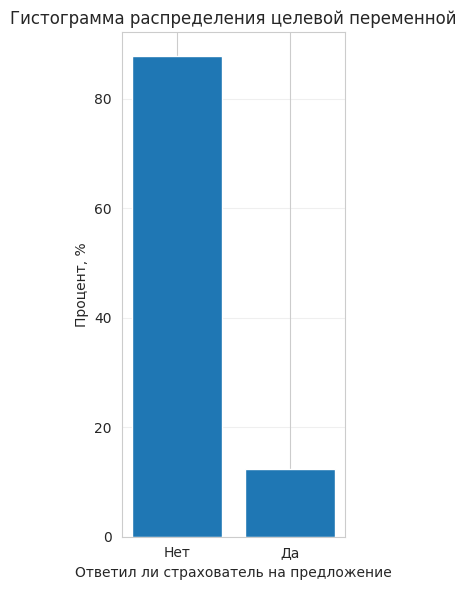

In [10]:
response_counts = df['Response'].value_counts().sort_index()
total_count = len(df)
percentages = (response_counts / total_count) * 100
plt.figure(figsize=(3, 6))
plt.bar(percentages.index.astype(str), percentages.values)
plt.title('Гистограмма распределения целевой переменной')
plt.xlabel('Ответил ли страхователь на предложение')
plt.ylabel('Процент, %')
plt.xticks(percentages.index, ['Нет', 'Да'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Вывод:**

Сильный дисбаланс классов: 85% клиентов отвечают «Нет», 15% — «Да».
Это может привести к смещению модели в сторону "Нет", если не использовать правильные метрики и методы балансировки.
Модель должна быть обучена не на точности (accuracy), а на способности находить редкие положительные случаи.

<a id="third"></a>
## 3. Анализ категориальных признаков

<a id="third-one"></a>
### 3.1 Бинарные признаки "Gender", "Driving_License", "Previously_Insured", "Vehicle_Damage"

In [11]:
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'No': 0, 'Yes': 1})

# переводим Dtype бинарных признаков в category
for col in binary_columns:
    df[col] = df[col].astype('category')

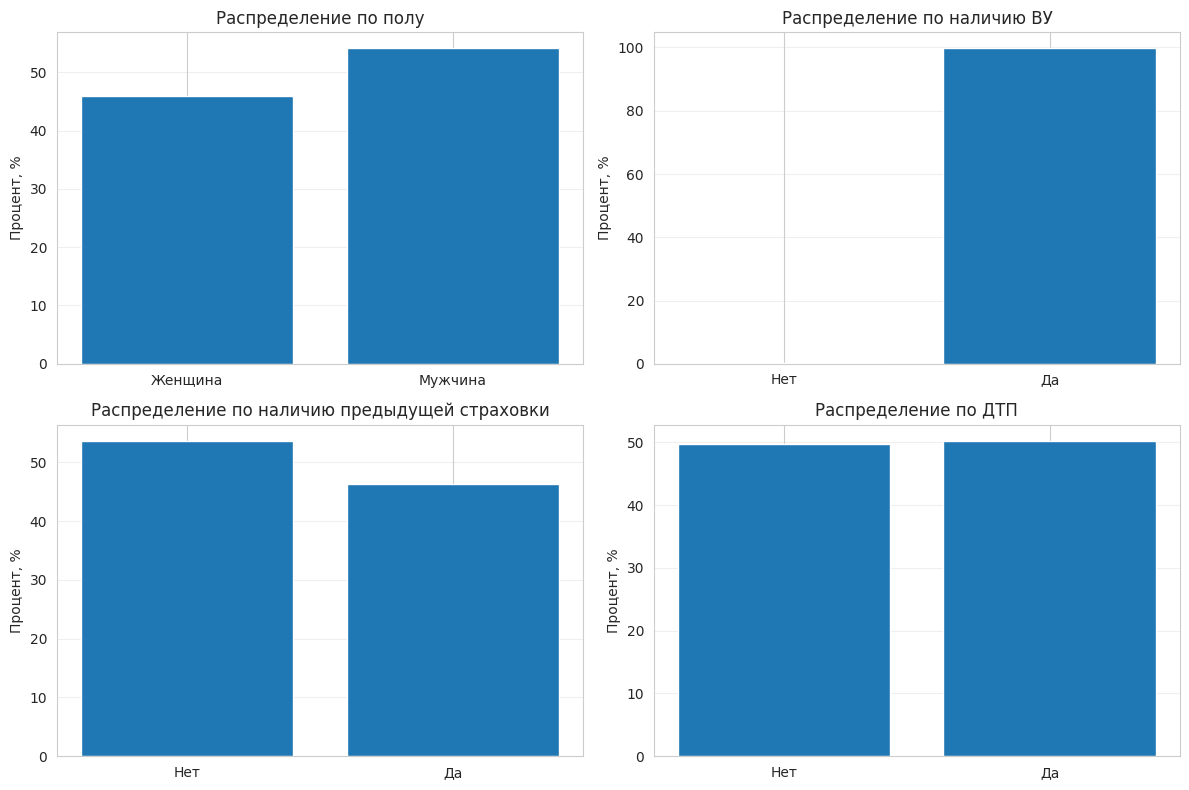

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

response_counts = df['Gender'].value_counts().sort_index()
response_percentages = (response_counts / len(df)) * 100
ax1.bar(['Женщина', 'Мужчина'], response_percentages.values)
ax1.set_title('Распределение по полу')
ax1.set_ylabel('Процент, %')
ax1.grid(axis='y', alpha=0.3)

dl_counts = df['Driving_License'].value_counts().sort_index()
dl_percentages = (dl_counts / len(df)) * 100
ax2.bar(['Нет', 'Да'], dl_percentages.values)
ax2.set_title('Распределение по наличию ВУ')
ax2.set_ylabel('Процент, %')
ax2.grid(axis='y', alpha=0.3)

pi_counts = df['Previously_Insured'].value_counts().sort_index()
pi_percentages = (pi_counts / len(df)) * 100
ax3.bar(['Нет', 'Да'], pi_percentages.values)
ax3.set_title('Распределение по наличию предыдущей страховки')
ax3.set_ylabel('Процент, %')
ax3.grid(axis='y', alpha=0.3)

vd_counts = df['Vehicle_Damage'].value_counts().sort_index()
vd_percentages = (vd_counts / len(df)) * 100
ax4.bar(['Нет', 'Да'], vd_percentages.values)
ax4.set_title('Распределение по ДТП')
ax4.set_ylabel('Процент, %')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**Вывод:**

- Мужчины чаше берут страховку - значимый признак
- Большая часть страхователей имеют ВУ - малополезен для модели, можно удалить
- Больше половины клиентов не имели предыдущей страховки - новые клиенты основная целевая аудитория
- Участие в ДТП в соотношении 50/50 - если были ДТП — выше вероятность покупки

Можно предположить, что мужчины с водительским удостоверением, впервые страхующиеся и участвовавшие в ДТП, с большей долей вероятности возьмут доп. страховку

<a id="third-two"></a>
### 3.2 Порядковый признак "Vehicle_Age"

In [13]:
vehicle_age_unique = df['Vehicle_Age'].unique()
print(vehicle_age_unique)

['1-2 Year' '> 2 Years' '< 1 Year']


In [14]:
df['Vehicle_Age'] = df['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}).astype('category')

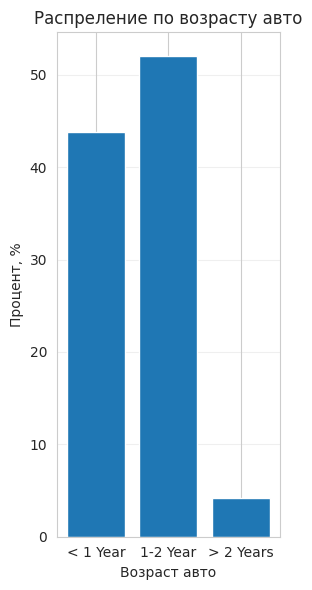

In [15]:
response_counts = df['Vehicle_Age'].value_counts().sort_index()
total_count = len(df)
percentages = (response_counts / total_count) * 100
plt.figure(figsize=(3, 6))
plt.bar(percentages.index.astype(str), percentages.values)
plt.title('Распреление по возрасту авто')
plt.xlabel('Возраст авто')
plt.ylabel('Процент, %')
plt.xticks(percentages.index, ['< 1 Year', '1-2 Year', '> 2 Years'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Вывод:**
- Чаще страхуют новые авто не старше 2-х лет

<a id="third-three"></a>
### 3.3 Высококардинальные признаки "Region_Code", "Policy_Sales_Channel"

In [16]:
region_code_unique = df['Region_Code'].unique()
print(region_code_unique)

[35.  28.  14.   1.  15.  47.  45.   8.  11.   3.  10.  12.  37.  50.
 30.  46.  29.  16.  26.  25.  41.  48.   7.   4.  24.  36.  33.   2.
  9.  27.  18.  43.  49.  17.  13.  38.   6.  21.  23.   0.  19.   5.
 39.  44.  20.  40.  22.  32.  42.  31.  34.  51.  52.  39.2]


Проверяем аномальное значение '39.2' на сколько часто встречается

In [17]:
print(df[df['Region_Code'] == 39.2].shape[0])

1


Так как значение '39.2' встречается только 1 раз, удаляем строку с ним из датасета:

In [18]:
df = df[df['Region_Code'] != 39.2]

Построим частотную гистограмму для визуализации признака "Region_Code"

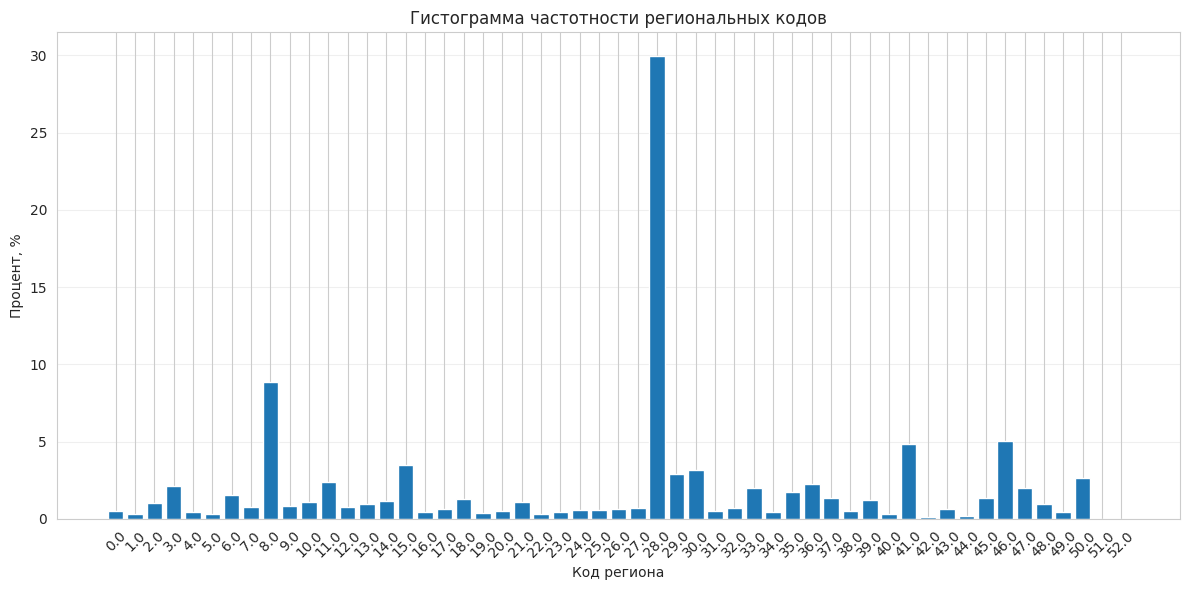

In [19]:
region_counts = df['Region_Code'].value_counts().sort_index()
total_count = len(df)
percentages = (region_counts / total_count) * 100
plt.figure(figsize=(12, 6))
plt.bar(percentages.index.astype(str), percentages.values)
plt.title('Гистограмма частотности региональных кодов')
plt.xlabel('Код региона')
plt.ylabel('Процент, %')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Выполним Frequency Encoding (частотное кодирование) для "Region_Code", чтобы заменить этот столбец на процентное представление частоты каждого региона:

In [20]:
region_percentages = (df['Region_Code'].value_counts() / len(df)) * 100
df['Region_Code_Percentage'] = df['Region_Code'].map(region_percentages)
df.drop('Region_Code', axis=1, inplace=True)

**Выводы по применению частотного кодирования:**
- "Region_Code" - это категории без порядка, следоваетльно, мы избегаем ложного порядка
- Снижение размерности
- Сохрание информации: регионы, где много клиентов, получают большие значения
- Безопасно с точки зрения утечки, не использует целевую переменную

In [21]:
policy_sales_channel_unique = df['Policy_Sales_Channel'].unique()
print(policy_sales_channel_unique)
print(f"Количество уникальных продавцов: {len(policy_sales_channel_unique)}")

[124.  26. 152. 156. 160.   8.  31. 157.  60. 122.  15.  30. 147.   1.
  63. 136. 154.  18. 135. 151.   3.  10.  55. 108.   7.  29. 163.  13.
 133. 145.  25.  12. 109.  23.  78.   4. 153. 150. 146. 120. 107. 155.
  61.  14.  45.  11.  19.  24.  52. 132. 125.  59.  16.  22.  56.  20.
 148. 158. 159. 139.   9. 113. 121.  21. 111.  64. 116. 103. 128.  65.
  37.  91. 129. 127. 106. 140.  35. 131.  17.  93.  90.  36. 118.  54.
  62. 138.  42.  46.  86.  80.  68. 119.  94.  48.  47.  83.  97.  70.
  53.  44. 114.  98.  88. 110.  32. 126.  96.  99. 130.  66. 105.  51.
  38. 137.  89.  81.  92. 117.  73.  69.  49.  87.  33.  39.  50. 123.
  75. 101. 115. 100.  95.  57.  71. 134.  82.   6.  58. 104.  41.  40.
   2.  79.  34.  76.  28.  74.  43.  67.  27. 112. 102.   5.]
Количество уникальных продавцов: 152


Построим частотную гистограмму для визуализации признака "Policy_Sales_Channel"

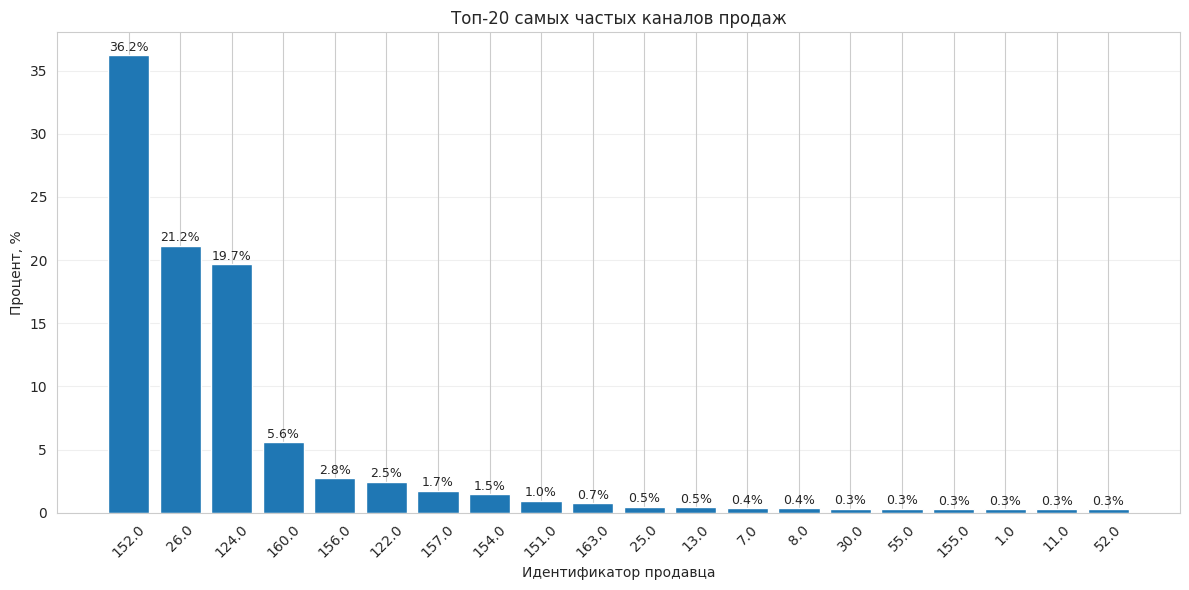

In [22]:
top_n = 20
channel_counts = df['Policy_Sales_Channel'].value_counts().head(top_n)
total_count = len(df)
percentages = (channel_counts / total_count) * 100

plt.figure(figsize=(12, 6))
bars = plt.bar(percentages.index.astype(str), percentages.values)
plt.title(f'Топ-{top_n} самых частых каналов продаж')
plt.xlabel('Идентификатор продавца')
plt.ylabel('Процент, %')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

for bar, percentage in zip(bars, percentages.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1,
             f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Реализуем Frequency Encoding (частотное кодирование) с предварительной группировкой редких категорий для признака "Policy_Sales_Channel":

Всего уникальных продавцов: 152
Продавцов с частотностью >1%: 8


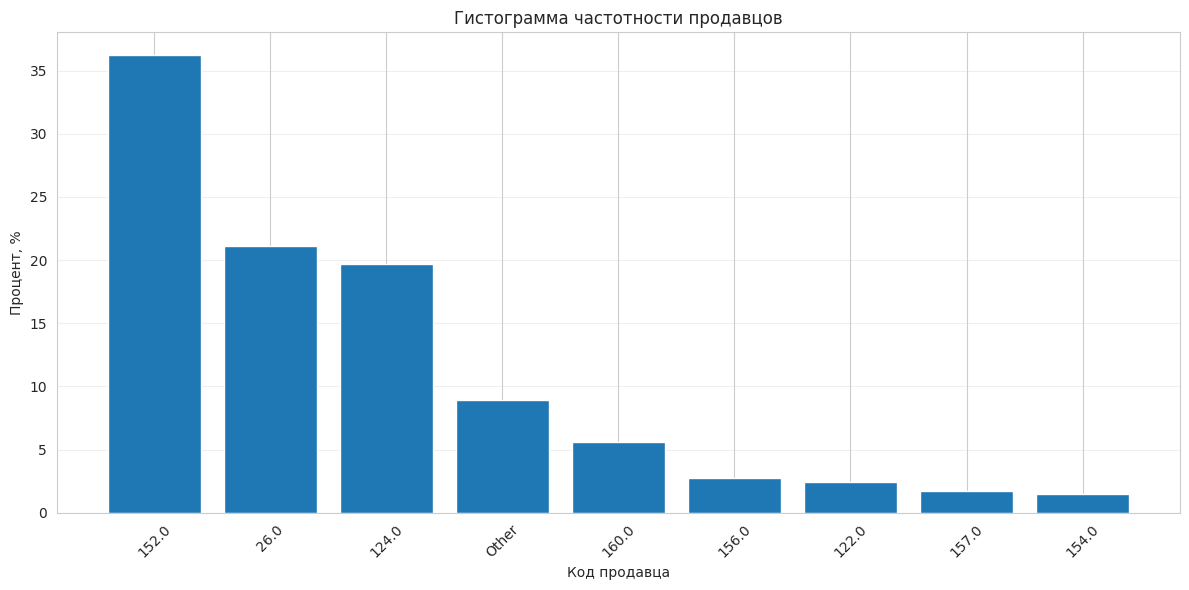

In [23]:
channel_counts = df['Policy_Sales_Channel'].value_counts(normalize=True) * 100
print(f"Всего уникальных продавцов: {len(channel_counts)}")

top_channels = channel_counts[channel_counts > 1].index
print(f"Продавцов с частотностью >1%: {len(top_channels)}")

df['Policy_Sales_Channel_Grouped'] = df['Policy_Sales_Channel'].apply(
    lambda x: x if x in top_channels else 'Other'
)

grouped_freq = df['Policy_Sales_Channel_Grouped'].value_counts(normalize=True)
channel_percentages = grouped_freq * 100

df['Policy_Sales_Channel_Percentage'] = df['Policy_Sales_Channel_Grouped'].map(channel_percentages)

plt.figure(figsize=(12, 6))
plt.bar(channel_percentages.index.astype(str), channel_percentages.values)
plt.title('Гистограмма частотности продавцов')
plt.xlabel('Код продавца')
plt.ylabel('Процент, %')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

df.drop('Policy_Sales_Channel', axis=1, inplace=True)
df.drop('Policy_Sales_Channel_Grouped', axis=1, inplace=True)


**Вывод:**
- Основная масса клиентов приходит через 3 ключевых канала: 152, 26, 124
- Группа "Other" - значимая, но не доминирующая
- Можно работать с ограниченным числом каналов, а остальные объединять

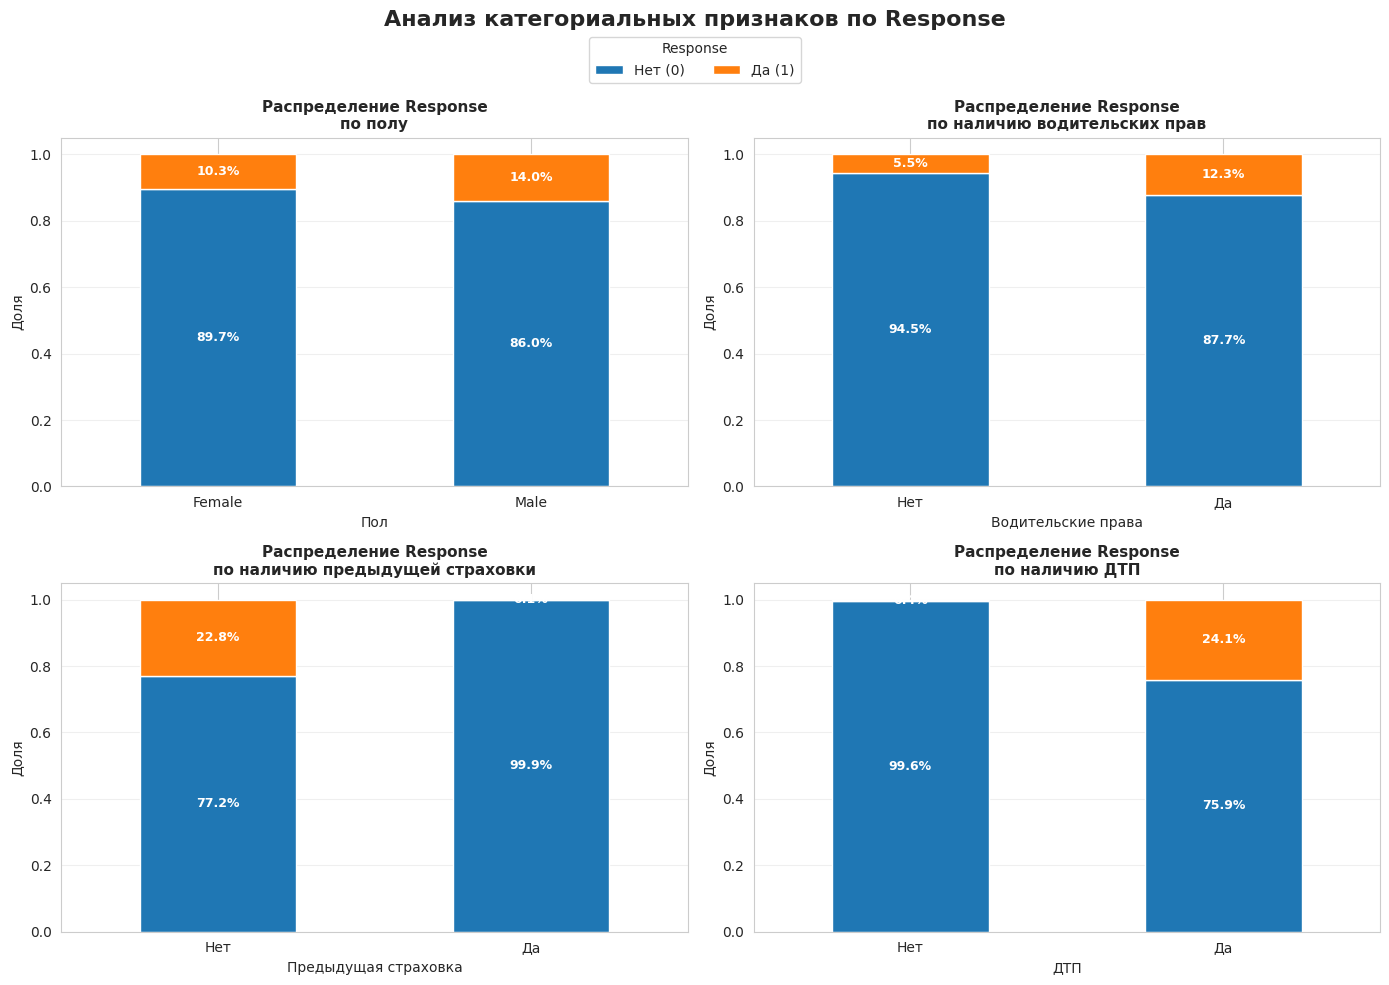

In [24]:
def plot_response_by_category(ax, category, title, xlabel):
    ct = pd.crosstab(category, df['Response'], normalize='index')

    bars = ct.plot(
        kind='bar',
        stacked=True,
        ax=ax,
        color=['#1f77b4', '#ff7f0e'],
        legend=False
    )

    for container in bars.containers:
        bars.bar_label(
            container,
            labels=[f'{v:.1%}' for v in container.datavalues],
            label_type='center',
            fontsize=9,
            color='white',
            weight='bold'
        )

    ax.set_title(f'Распределение Response\nпо {title}', fontsize=11, weight='bold')
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel('Доля', fontsize=10)
    ax.tick_params(axis='x', rotation=0)
    ax.grid(axis='y', alpha=0.3)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Анализ категориальных признаков по Response', fontsize=16, weight='bold')

axes = axes.flatten()

categories = [
    df['Gender'].map({0: 'Female', 1: 'Male'}),
    df['Driving_License'].map({0: 'Нет', 1: 'Да'}),
    df['Previously_Insured'].map({0: 'Нет', 1: 'Да'}),
    df['Vehicle_Damage'].map({0: 'Нет', 1: 'Да'})
]

titles = [
    'полу',
    'наличию водительских прав',
    'наличию предыдущей страховки',
    'наличию ДТП'
]

xlabels = ['Пол', 'Водительские права', 'Предыдущая страховка', 'ДТП']

for i in range(4):
    plot_response_by_category(axes[i], categories[i], titles[i], xlabels[i])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ['Нет (0)', 'Да (1)'], title='Response', loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.96))

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

**Вывод:**

1. Мужчины чаще берут доп страховку, нежели женщины
2. Люди с ВУ чаще берут доп страховку, нежели без ВУ
3. Люди, без предыдущей страховки, чаще берут доп страховку. Те, кто продлевает, практически никогда не берут доп страховку
4. Люди, ранее попадавшие в ДТП, чаще берут страховку. Те, кто не попадал в ДТП,  практически никогда не берут доп страховку

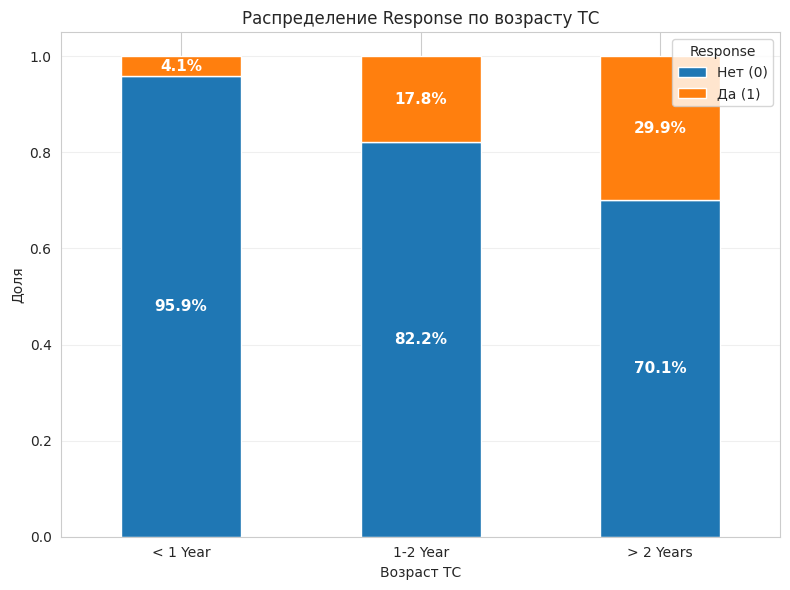

In [25]:
ct = pd.crosstab(df['Vehicle_Age'].map({0: '< 1 Year', 1: '1-2 Year', 2: '> 2 Years'}), df['Response'], normalize='index')

ax = ct.plot(kind='bar', stacked=True, figsize=(8, 6), color=['#1f77b4', '#ff7f0e'])

for container in ax.containers:
    ax.bar_label(container,
                 labels=[f'{v:.1%}' for v in container.datavalues],
                 label_type='center', fontsize=11, color='white', weight='bold')

plt.title('Распределение Response по возрасту ТС')
plt.xlabel('Возраст ТС')
plt.ylabel('Доля')
plt.xticks(rotation=0)
plt.legend(title='Response', labels=['Нет (0)', 'Да (1)'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Вывод:**
- чем старше авто, тем выше вероятность, что человек возьмет доп страховку

Для определения распределения "Response" по "Region_Code_Percentage" и по "Policy_Sales_Channel_Percentage" необходимо агрегировать данные: для каждого значения "Region_Code_Percentage" и "Policy_Sales_Channel_Percentage" посчитать среднее значение "Response"

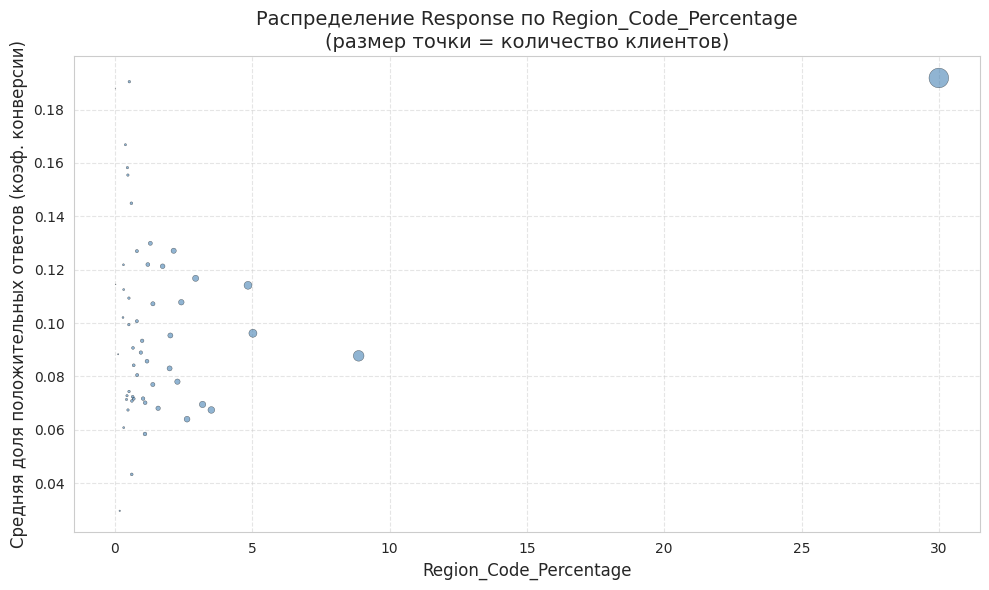

In [26]:
df['Response'] = pd.to_numeric(df['Response'])
df['Region_Code_Percentage'] = pd.to_numeric(df['Region_Code_Percentage'])

agg_df = df.groupby('Region_Code_Percentage')['Response'].agg(['mean', 'size']).reset_index()
agg_df = agg_df.sort_values('Region_Code_Percentage')

sizes = agg_df['size'] / agg_df['size'].max() * 200

plt.figure(figsize=(10, 6))
plt.scatter(
    agg_df['Region_Code_Percentage'],
    agg_df['mean'],
    s=sizes,
    color='steelblue',
    alpha=0.6,
    edgecolor='k',
    linewidth=0.3
)

plt.xlabel('Region_Code_Percentage', fontsize=12)
plt.ylabel('Средняя доля положительных ответов (коэф. конверсии)', fontsize=12)
plt.title('Распределение Response по Region_Code_Percentage\n(размер точки = количество клиентов)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Вывод:**
- Популярность региона коррелирует с конверсией - чем больше клиентов в регионе, тем выше вероятность, что они купят допуслугу

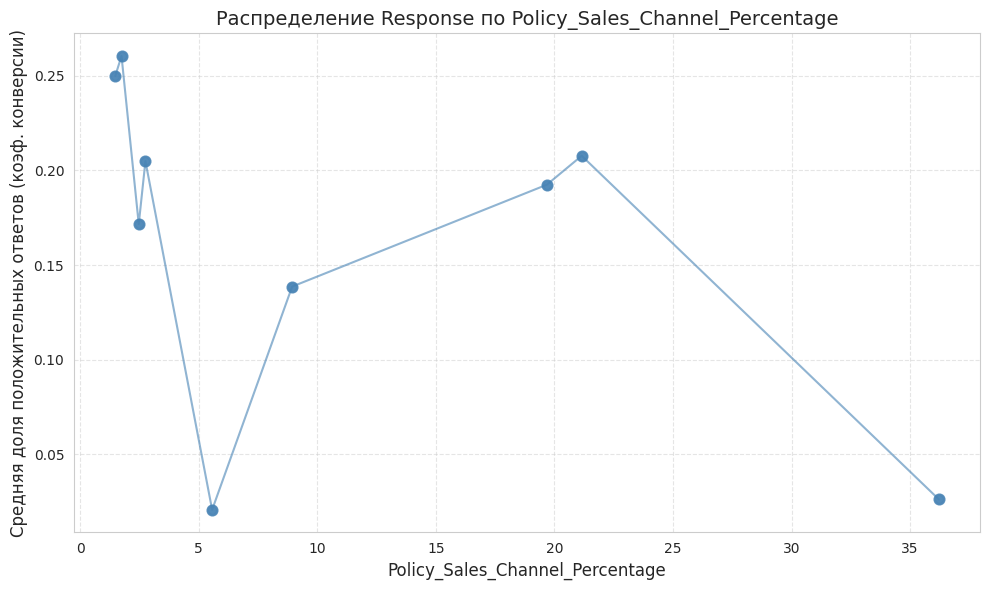

In [27]:
df['Response'] = pd.to_numeric(df['Response'])
df['Policy_Sales_Channel_Percentage'] = pd.to_numeric(df['Policy_Sales_Channel_Percentage'])

# Агрегация: среднее значение Response по каждому уникальному Policy_Sales_Channel_Percentage
agg_df = df.groupby('Policy_Sales_Channel_Percentage')['Response'].mean().reset_index()
agg_df = agg_df.sort_values('Policy_Sales_Channel_Percentage')

plt.figure(figsize=(10, 6))
plt.scatter(agg_df['Policy_Sales_Channel_Percentage'], agg_df['Response'], color='steelblue', s=60, alpha=0.8)
plt.plot(agg_df['Policy_Sales_Channel_Percentage'], agg_df['Response'], color='steelblue', linestyle='-', marker='o', alpha=0.6)

plt.xlabel('Policy_Sales_Channel_Percentage', fontsize=12)
plt.ylabel('Средняя доля положительных ответов (коэф. конверсии)', fontsize=12)
plt.title('Распределение Response по Policy_Sales_Channel_Percentage', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Вывод:**
- Конверсия по каналам продаж нелинейно зависит от их популярности - не самые массовые, а нишевые или средние каналы работают лучше всего

<a id="fource"></a>
## Анализ числовых признаков "Age", "Annual_Premium", "Vintage"

In [28]:
df[['Age', 'Annual_Premium', 'Vintage']].describe().drop('count').round(0)

,Age,Annual_Premium,Vintage
mean,38.00,"30,461.00",164.00
std,15.00,"16,455.00",80.00
min,20.00,"2,630.00",10.00
25%,24.00,"25,277.00",99.00
50%,36.00,"31,824.00",166.00
75%,49.00,"39,451.00",232.00
max,85.00,"540,165.00",299.00


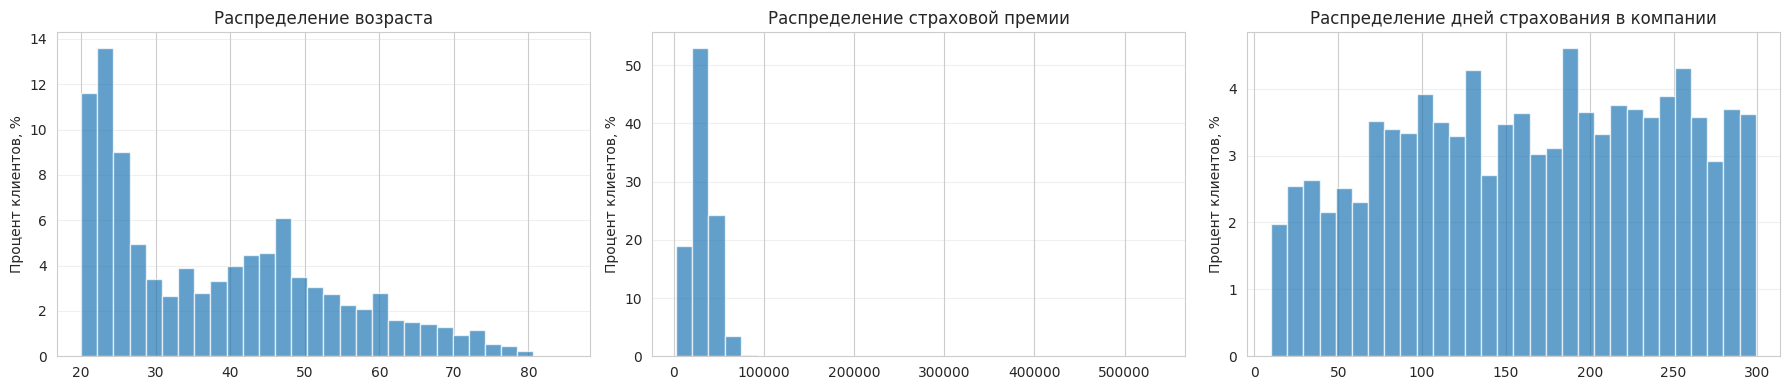

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

def plot_true_percentage_hist(data, ax, title, bins=30):
    counts, bins, patches = ax.hist(data, bins=bins, alpha=0.7, weights=np.ones(len(data)) / len(data) * 100)
    ax.set_title(title)
    ax.set_ylabel('Процент клиентов, %')
    ax.grid(axis='y', alpha=0.3)
    return counts, bins, patches

# Возраст
counts1, bins1, patches1 = plot_true_percentage_hist(df['Age'], ax1, 'Распределение возраста')

# Годовая премия
counts2, bins2, patches2 = plot_true_percentage_hist(df['Annual_Premium'], ax2, 'Распределение страховой премии')

# Vintage
counts3, bins3, patches3 = plot_true_percentage_hist(df['Vintage'], ax3, 'Распределение дней страхования в компании')

plt.tight_layout()
plt.show()

**Вывод:**

1. Основной возраст страхования: 20-30, 40-50
2. Нелинейная связь, есть выбросы
3. Клиенты равномерно распределены по времени, но с небольшим пиком в районе 200 дней

Для наглядности распределения "Annual_Premium" используем скрипичный график с логарифмированием:

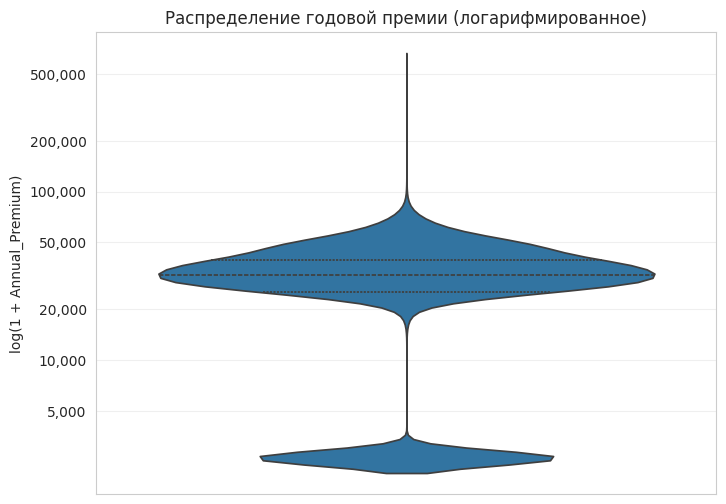

In [30]:
sample = df.sample(n=100_000, random_state=42)

plt.figure(figsize=(8, 6))
sns.violinplot(
    y=np.log1p(sample['Annual_Premium']),
    inner='quartile'
)

plt.title('Распределение годовой премии (логарифмированное)')
plt.ylabel('log(1 + Annual_Premium)')

yticks_original = [5_000, 10_000, 20_000, 50_000, 100_000, 200_000, 500_000]
yticks_original = [x for x in yticks_original
                   if sample['Annual_Premium'].min() <= x <= sample['Annual_Premium'].max()]
yticks_log = np.log1p(yticks_original)

plt.yticks(yticks_log, [f'{x:,}' for x in yticks_original])
plt.grid(axis='y', alpha=0.3)
plt.show()

**Вывод по распределению "Annual_Premium":**
- Распределение сильно скошено вправо
- Необходимо логарифмирование для превращения мультипликативного отношения в аддитивное

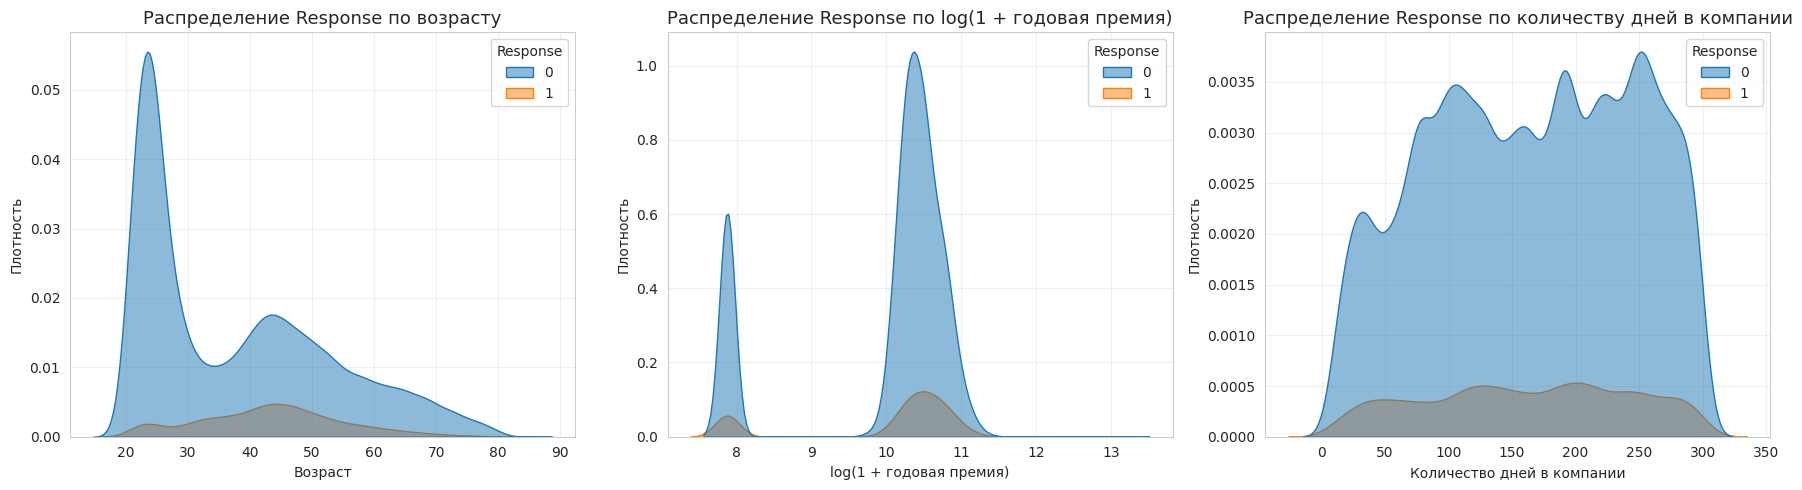

In [31]:
sample = df.sample(n=100_000, random_state=42)

sample['Log_Annual_Premium'] = np.log1p(sample['Annual_Premium'])

num_features = ['Age', 'Log_Annual_Premium', 'Vintage']
titles = ['возрасту', 'log(1 + годовая премия)', 'количеству дней в компании']
feature_labels = ['Возраст', 'log(1 + годовая премия)', 'Количество дней в компании']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(num_features):
    sns.kdeplot(
        data=sample,
        x=col,
        hue='Response',
        ax=axes[i],
        fill=True,
        alpha=0.5,
        palette=['#1f77b4', '#ff7f0e']
    )
    axes[i].set_title(f'Распределение Response по {titles[i]}', fontsize=13)
    axes[i].set_xlabel(feature_labels[i])
    axes[i].set_ylabel('Плотность')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Выводы:**

1. Распределение по возрасту:
- молодые клиенты (до 30) реже покупают допстраховку
- клиенты 40–50 лет чаще покупают доп страховку

2. Распределение по log(1 + годовая премия):
- клиенты, которые чаще покупают доп страховку, платят больше
- чем дороже полис - тем выше вероятность согласия

3. Распределение по количеству дней в компании:
- "устоявшиеся" клиенты чаще покупают доп страховку

<a id="fifth"></a>
## Корреляционный анализ по числовым признакам

interval columns not set, guessing: ['Age', 'Annual_Premium', 'Vintage', 'Response', 'Region_Code_Percentage', 'Policy_Sales_Channel_Percentage']


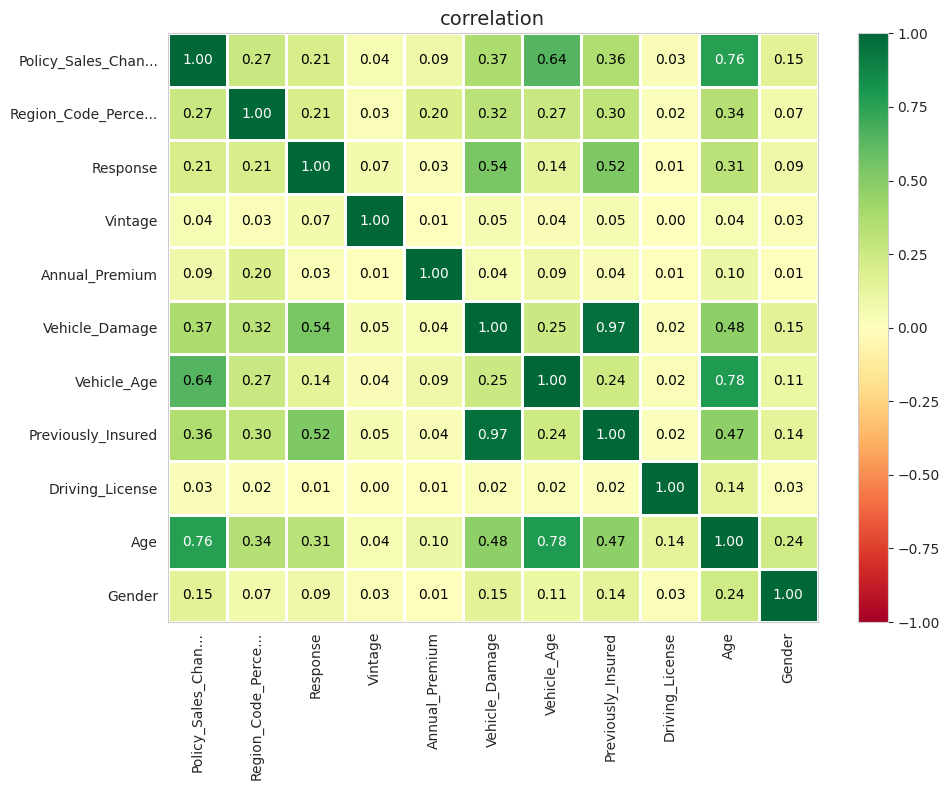

In [32]:
corr_matrix = df.phik_matrix()
plot_correlation_matrix(corr_matrix.values, x_labels=corr_matrix.columns, y_labels=corr_matrix.index, figsize=(10, 8))

**Вывод:**
- Корреляция "Response" и "Vehicle_Damage" +0.54                  - сильный признак (клиенты с ДТП значительно чаще покупают доп страховку)
- Корреляция "Response" и "Previously_Insured" +0.52              - сильный признак (не застрахованные ранее - основная целевая аудитория)
- Корреляция "Response" и "Age" +0.31                             - умеренный признак (старшие клиенты чаще соглашаются на доп страховку)
- Корреляция "Response" и "Region_Code_Percentage" +0.21          - умеренный признак (клиенты из популярных регионов чаще соглашаются на доп страховку)
- Корреляция "Response" и "Policy_Sales_Channel_Percentage" +0.21 - умеренный признак (клиенты из популярных каналов продаж чаще соглашаются на доп страховку)
- Корреляция "Response" и "Vehicle_Age" +0.14                     - слабый признак, но полезный (старые авто - выше вероятность согласия на доп страховку)
- Остальные признаки слабо коррелируют с целевой переменной "Response"

<a id="sixth"></a>
## 6. Модели

In [33]:
df = pd.read_csv(FILE_PATH, index_col='id')

### Baseline - логистическая регрессия

**Обоснования выбора логистической регрессии:**
- Простота и интерпретируемость - коэффициенты показывают, как каждый признак влияет на вероятность.
- Быстрое обучение и предсказание - обучение за секунды и позволяет быстро проверять гипотезы.
- Хороший ориентир для качества - если сложная модель не превосходит логистическую регрессию, то возможно проблема в данных, а не в модели.
- Чувствительность к качеству признаков - хорошего результата - качественная подготовка признаков.

**Валидация:**
- Проведем кросс-валидацию.
- Применим стратифицированное разделение, так как 85% клиентов отвечают «Нет», 15% — «Да», что является дисбалансом. Такое разделение гарантирует, что доля каждого класса в train и test будет такой же, как в исходном датасете.

**Метрика качества:**
В задаче с дисбалансом (85% - «0» и 15% - «1») метрика F1 важна, потому что она сочетает точность (Precision) и полноту (Recall) — то есть учитывает и то, насколько мы уверены в «1», и то, сколько «1» мы вообще нашли.

### Кастомный трансформер для частотного кодирования

**Что делаем**: Создаем собственный класс для частотного кодирования.

**Зачем**: Для преобразования категориальных признаков с высокой кардинальностью (много уникальных значений).

**Почему Frequency Encoding вместо One-Hot Encoding**:
- One-Hot создает слишком много признаков для Region_Code и Policy_Sales_Channel
- Частотное кодирование сохраняет информацию о популярности категории
- Преобразует категории в числа, сохраняя информацию о распределении
- Не создает проблем с размерностью данных

**Почему кастомный класс, а не готовое решение**:
- Больше контроля над процессом
- Легче интегрировать в sklearn пайплайн
- Прозрачность преобразований

In [34]:
class ThresholdFrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.01, other_name='OTHER'):
        self.threshold = threshold
        self.other_name = other_name
        self.freq_maps_ = {}
        self.columns_ = []

    def fit(self, X, y=None):
        self.columns_ = X.columns.tolist()

        for col in self.columns_:
            value_counts = X[col].value_counts(normalize=True)
            common_categories = value_counts[value_counts >= self.threshold].index
            freq_map = {}
            for cat in common_categories:
                freq_map[cat] = value_counts[cat]
            other_categories = value_counts[value_counts < self.threshold].index
            other_freq = value_counts[other_categories].sum() if len(other_categories) > 0 else 0
            freq_map[self.other_name] = other_freq
            self.freq_maps_[col] = freq_map

        return self

    def transform(self, X):
        X_copy = X.copy()

        for col in self.columns_:
            if col not in X_copy.columns:
                continue
            temp_col = X_copy[col].astype(str)
            common_categories = list(self.freq_maps_[col].keys())
            common_categories.remove(self.other_name)
            temp_col = temp_col.where(
                temp_col.isin(common_categories),
                other=self.other_name
            )
            encoded_values = temp_col.map(self.freq_maps_[col])
            encoded_values = encoded_values.fillna(self.freq_maps_[col][self.other_name])
            X_copy[col] = encoded_values

        return X_copy

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return self.columns_
        return input_features


def evaluate_pipeline(pipeline, X_train, X_test, y_train, y_test, name):
    X_train_copy = X_train.copy()
    y_train_copy = y_train.copy()
    pipeline.fit(X_train_copy, y_train_copy)
    y_pred = pipeline.predict(X_test)

    if hasattr(pipeline, "predict_proba"):
        y_proba = pipeline.predict_proba(X_test)[:, 1]
    else:
        y_proba = pipeline.decision_function(X_test)

    return {
        'Model': name,
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }, confusion_matrix(y_test, y_pred)

### Подготовка данных

**Что делаем**: Отбираем подвыборку данных и разделяем на train/test.

**Зачем**:
- Оригинальный датасет слишком большой (11+ млн строк)
- Для экспериментов достаточно 1.5 млн строк
- Ускоряет обучение и отладку моделей

**Почему именно 1.5 млн строк**:
- Достаточно для обучения сложной модели
- Позволяет сохранить распределение данных
- Обучение проходит за разумное время
- Можно провести несколько экспериментов

**Почему стратифицированное разделение**:
- Дисбаланс классов (88%/12%)
- Сохраняем пропорции классов в train и test
- Избегаем ситуаций, когда в test не будет представителей миноритарного класса

In [35]:
df_sample = df.sample(n=1500000, random_state=42)

X = df_sample.drop("Response", axis=1)
y = df_sample["Response"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=1000000,
    test_size=500000,
    stratify=y,
    random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Class balance in train: {y_train.value_counts(normalize=True)}")


Train shape: (1000000, 10)
Test shape: (500000, 10)
Class balance in train: Response
0   0.88
1   0.12
Name: proportion, dtype: float64


In [36]:
def get_model_file(path):
    response = requests.get(MODELS_BASE_PATH + path)
    response.raise_for_status()

    mfile = BytesIO(response.content)

    return joblib.load(mfile)

### Преобработка признаков

**Что делаем**: Создаем пайплайн преобразования признаков.

**Зачем**: Привести все признаки к числовому виду для работы модели.

**Почему разные стратегии кодирования для разных типов признаков**:

**Для высококардинальных (Region_Code, Policy_Sales_Channel)**:
- Frequency Encoding — сохраняет информацию о частоте
- Избегаем проклятия размерности

**Для бинарных (Gender, Vehicle_Damage)**:
One-Hot Encoding с drop='first'
- Убираем мультиколлинеарность
- Получаем интерпретируемые признаки

**Для порядковых (Vehicle_Age)**:
- Ordinal Encoding с сохранением порядка
- Порядок важен: < 1 Year < 1-2 Year < > 2 Years

In [37]:
high_card_cols = ['Region_Code', 'Policy_Sales_Channel']
bool_cols = ['Gender', 'Vehicle_Damage']
ord_cols = ['Vehicle_Age']

preprocessor = ColumnTransformer(
    transformers=[
        ("high_cat", ThresholdFrequencyEncoder(threshold=0.01, other_name='OTHER'), high_card_cols),
        ("bool", OneHotEncoder(drop='first', sparse_output=False, dtype=np.int32), bool_cols),
        ("ord", OrdinalEncoder(
            categories=[['< 1 Year', '1-2 Year', '> 2 Years']],
            dtype=np.int32
        ), ord_cols),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [38]:
results = []
conf_matrices = {}

### Модели для сравнения

**Что делаем**: Обучаем модели для сравнения.

**Зачем**: Поиск лучшей модели для бизнесс задачи.

### Logistic Regression (HalvingGridSearchCV)

In [39]:
lr_pipeline = get_model_file('logreg_halving.pkl')

start = time.time()

metrics_lr, cm_lr = evaluate_pipeline(
    lr_pipeline, X_train, X_test, y_train, y_test, "LogisticRegression"
)
metrics_lr['Time (sec)'] = round(time.time() - start, 2)

results.append(metrics_lr)
conf_matrices["LogisticRegression"] = cm_lr

print("Метрики LogisticRegression:")
print({k: v for k, v in metrics_lr.items() if k != 'Time (sec)'})

Метрики LogisticRegression:
{'Model': 'LogisticRegression', 'Precision': 0.25348730800391234, 'Recall': 0.9802444686135415, 'F1': 0.40280964832701854, 'ROC-AUC': 0.8346874581495244}


### Decision Tree (HalvingGridSearchCV)

In [40]:
dt_pipeline = get_model_file('des_tree_halving.pkl')

start = time.time()

metrics_dt, cm_dt = evaluate_pipeline(
    dt_pipeline, X_train, X_test, y_train, y_test, "DecisionTree"
)
metrics_dt['Time (sec)'] = round(time.time() - start, 2)

results.append(metrics_dt)
conf_matrices["DecisionTree"] = cm_dt

print("Метрики DecisionTree:")
print({k: v for k, v in metrics_dt.items() if k != 'Time (sec)'})

Метрики DecisionTree:
{'Model': 'DecisionTree', 'Precision': 0.28380845317031195, 'Recall': 0.9261886596431992, 'F1': 0.4344806579348157, 'ROC-AUC': 0.8460476905506829}


### RandomForest (Optuna)

In [41]:
rf_preprocessor = get_model_file('random_forest_preprocessor.pkl')
rf_model_data = get_model_file('random_forest_optuna.pkl')
rf_model = rf_model_data['model']

rf_pipeline = Pipeline([
    ('preprocessor', rf_preprocessor),
    ('classifier', rf_model)
])

start = time.time()
metrics_rf, cm_rf = evaluate_pipeline(
    rf_pipeline, X_train, X_test, y_train, y_test, "RandomForest"
)
metrics_rf['Time (sec)'] = round(time.time() - start, 2)

results.append(metrics_rf)
conf_matrices["RandomForest"] = cm_rf

print("Метрики RandomForest:")
print({k: v for k, v in metrics_rf.items() if k != 'Time (sec)'})

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  4.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 135 out of 135 | elapsed:    8.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 135 out of 135 | elapsed:    6.8s finished


Метрики RandomForest:
{'Model': 'RandomForest', 'Precision': 0.30797045971189974, 'Recall': 0.848887229518043, 'F1': 0.4519694907197338, 'ROC-AUC': 0.858079791231941}


### Gradient Boosting (Optuna)

In [42]:
optuna_boost_params = {
    'n_estimators': 245,
    'max_depth': 7,
    'learning_rate': 0.15604312608566637,
    'subsample': 0.8182611788035248,
    'min_samples_split': 14,
    'min_samples_leaf': 5
}
optuna_boost_params_prefixed = {f'classifier__{k}': v for k, v in optuna_boost_params.items()}

sample_weights = compute_sample_weight('balanced', y_train)

full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

pipeline = clone(full_pipeline)
pipeline.set_params(**optuna_boost_params_prefixed)
pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weights)

start = time.time()

y_pred = pipeline.predict(X_test)
if hasattr(pipeline, "predict_proba"):
    y_proba = pipeline.predict_proba(X_test)[:, 1]
else:
    y_proba = pipeline.decision_function(X_test)

metrics_gb = {
    'Model': "GradientBoosting",
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_proba)
}
cm_gb = confusion_matrix(y_test, y_pred)

metrics_gb['Time (sec)'] = round(time.time() - start, 2)

results.append(metrics_gb)
conf_matrices["GradientBoosting"] = cm_gb

print("Метрики GradientBoosting:")
print({k: v for k, v in metrics_gb.items() if k != 'Time (sec)'})


Метрики GradientBoosting:
{'Model': 'GradientBoosting', 'Precision': 0.2967170121334681, 'Recall': 0.9146145479927925, 'F1': 0.44807170037894, 'ROC-AUC': 0.8706943531354965}


### LightGBM (Optuna)

In [43]:
lgbm_model = get_model_file('lightgbm_optuna.pkl')

start = time.time()

lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lgbm_model)
])

start = time.time()

metrics_lgbm, cm_lgbm = evaluate_pipeline(
    lgbm_pipeline, X_train, X_test, y_train, y_test, "LightGBM"
)
metrics_lgbm['Time (sec)'] = round(time.time() - start, 2)

results.append(metrics_lgbm)
conf_matrices["LightGBM"] = cm_lgbm

print("Метрики LightGBM:")
print({k: v for k, v in metrics_lgbm.items() if k != 'Time (sec)'})

Метрики LightGBM:
{'Model': 'LightGBM', 'Precision': 0.30479860537664005, 'Recall': 0.8628151226401312, 'F1': 0.45046549174318923, 'ROC-AUC': 0.8610278474770439}


### LinearSVC (Optuna)

In [44]:
lsvm_pipeline = get_model_file('linear_svc_optuna.joblib')

X_test_small, _, y_test_small, _ = train_test_split(
    X_test, y_test,
    train_size=150000,
    stratify=y_test,
    random_state=42
)

X_train_small, _, y_train_small, _ = train_test_split(
    X_train, y_train,
    train_size=150000,
    stratify=y_train,
    random_state=42
)

start = time.time()

metrics_lsvm, cm_lsvm = evaluate_pipeline(
    lsvm_pipeline,
    X_train_small, X_test_small,
    y_train_small, y_test_small,
    "LSVC (150k)"
)
metrics_lsvm['Time (sec)'] = round(time.time() - start, 2)

results.append(metrics_lsvm)
conf_matrices["LSVC (150k)"] = cm_lsvm

print("Метрики LSVC (150k):")
print({k: v for k, v in metrics_lsvm.items() if k != 'Time (sec)'})

Метрики LSVC (150k):
{'Model': 'LSVC (150k)', 'Precision': 0.25400560224089636, 'Recall': 0.9813321789946432, 'F1': 0.40355581268566215, 'ROC-AUC': 0.8061825442212893}


### CatBoost (Optuna)

In [45]:
cb_model = get_model_file('catboost_optuna.pkl')

cb_df = df.copy()

cb_df['Gender'] = cb_df['Gender'].map({'Female': 0, 'Male': 1})
cb_df['Vehicle_Damage'] = cb_df['Vehicle_Damage'].map({'No': 0, 'Yes': 1})
cb_df['Vehicle_Age'] = cb_df['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})

cb_df['Region_Code'] = cb_df['Region_Code'].astype(str)
cb_df['Policy_Sales_Channel'] = cb_df['Policy_Sales_Channel'].astype(str)

cb_df_sample = cb_df.sample(n=1500000, random_state=42)
X = cb_df_sample.drop("Response", axis=1)
y = cb_df_sample["Response"]
cb_X_train, cb_X_test, cb_y_train, cb_y_test = train_test_split( X, y, train_size=1000000, test_size=500000, stratify=y, random_state=42 )

start = time.time()

y_pred_cb = cb_model.predict(cb_X_test)
y_proba_cb = cb_model.predict_proba(cb_X_test)[:, 1]

metrics_cb = {
    'Model': 'CatBoost',
    'Precision': precision_score(cb_y_test, y_pred_cb),
    'Recall': recall_score(cb_y_test, y_pred_cb),
    'F1': f1_score(cb_y_test, y_pred_cb),
    'ROC-AUC': roc_auc_score(cb_y_test, y_proba_cb),
    'Time (sec)': round(time.time() - start, 2)
}

cm_cb = confusion_matrix(cb_y_test, y_pred_cb)

results.append(metrics_cb)
conf_matrices['CatBoost'] = cm_cb

print("Метрики CatBoost:")
print({k: v for k, v in metrics_cb.items() if k != 'Time (sec)'})

Метрики CatBoost:
{'Model': 'CatBoost', 'Precision': 0.30459497613069386, 'Recall': 0.9176663474181452, 'F1': 0.4573761008426478, 'ROC-AUC': 0.8781436510503123}


### Сравнительная таблица метрик моделей

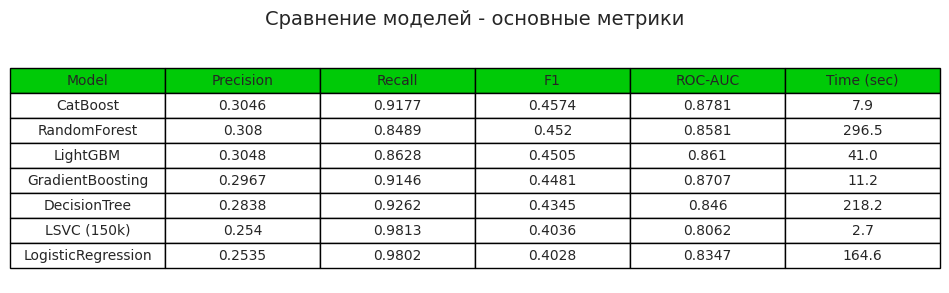

In [46]:
results_df = pd.DataFrame(results)
results_df = results_df[['Model', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'Time (sec)']]
results_df = results_df.sort_values('F1', ascending=False).reset_index(drop=True)

def plot_metrics_table(results_df):
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis('tight')
    ax.axis('off')

    df_display = results_df.copy()
    df_display['Precision'] = df_display['Precision'].round(4)
    df_display['Recall'] = df_display['Recall'].round(4)
    df_display['F1'] = df_display['F1'].round(4)
    df_display['ROC-AUC'] = df_display['ROC-AUC'].round(4)
    df_display['Time (sec)'] = df_display['Time (sec)'].round(1)

    table = ax.table(
        cellText=df_display.values,
        colLabels=df_display.columns,
        cellLoc='center',
        loc='center',
        colColours=["#00CA07"] * len(df_display.columns)  # зелёная шапка
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    plt.title("Сравнение моделей - основные метрики", fontsize=14, pad=20)
    plt.show()

plot_metrics_table(results_df)

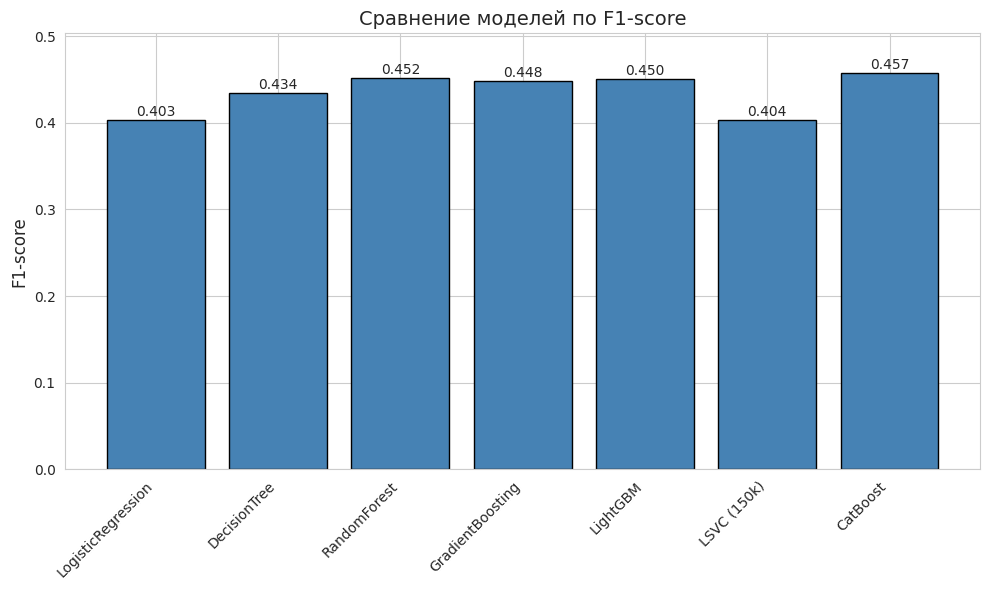

In [47]:
def plot_f1_comparison(results, figsize=(10, 6)):
    models = [r['Model'] for r in results]
    f1_scores = [r['F1'] for r in results]

    plt.figure(figsize=figsize)
    bars = plt.bar(models, f1_scores, color='steelblue', edgecolor='black')

    for bar, f1 in zip(bars, f1_scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001,
                 f'{f1:.3f}', ha='center', va='bottom', fontsize=10)

    plt.title('Сравнение моделей по F1-score', fontsize=14)
    plt.ylabel('F1-score', fontsize=12)
    plt.ylim(0, max(f1_scores) * 1.1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_f1_comparison(results)

### Матрицы ошибок моделей

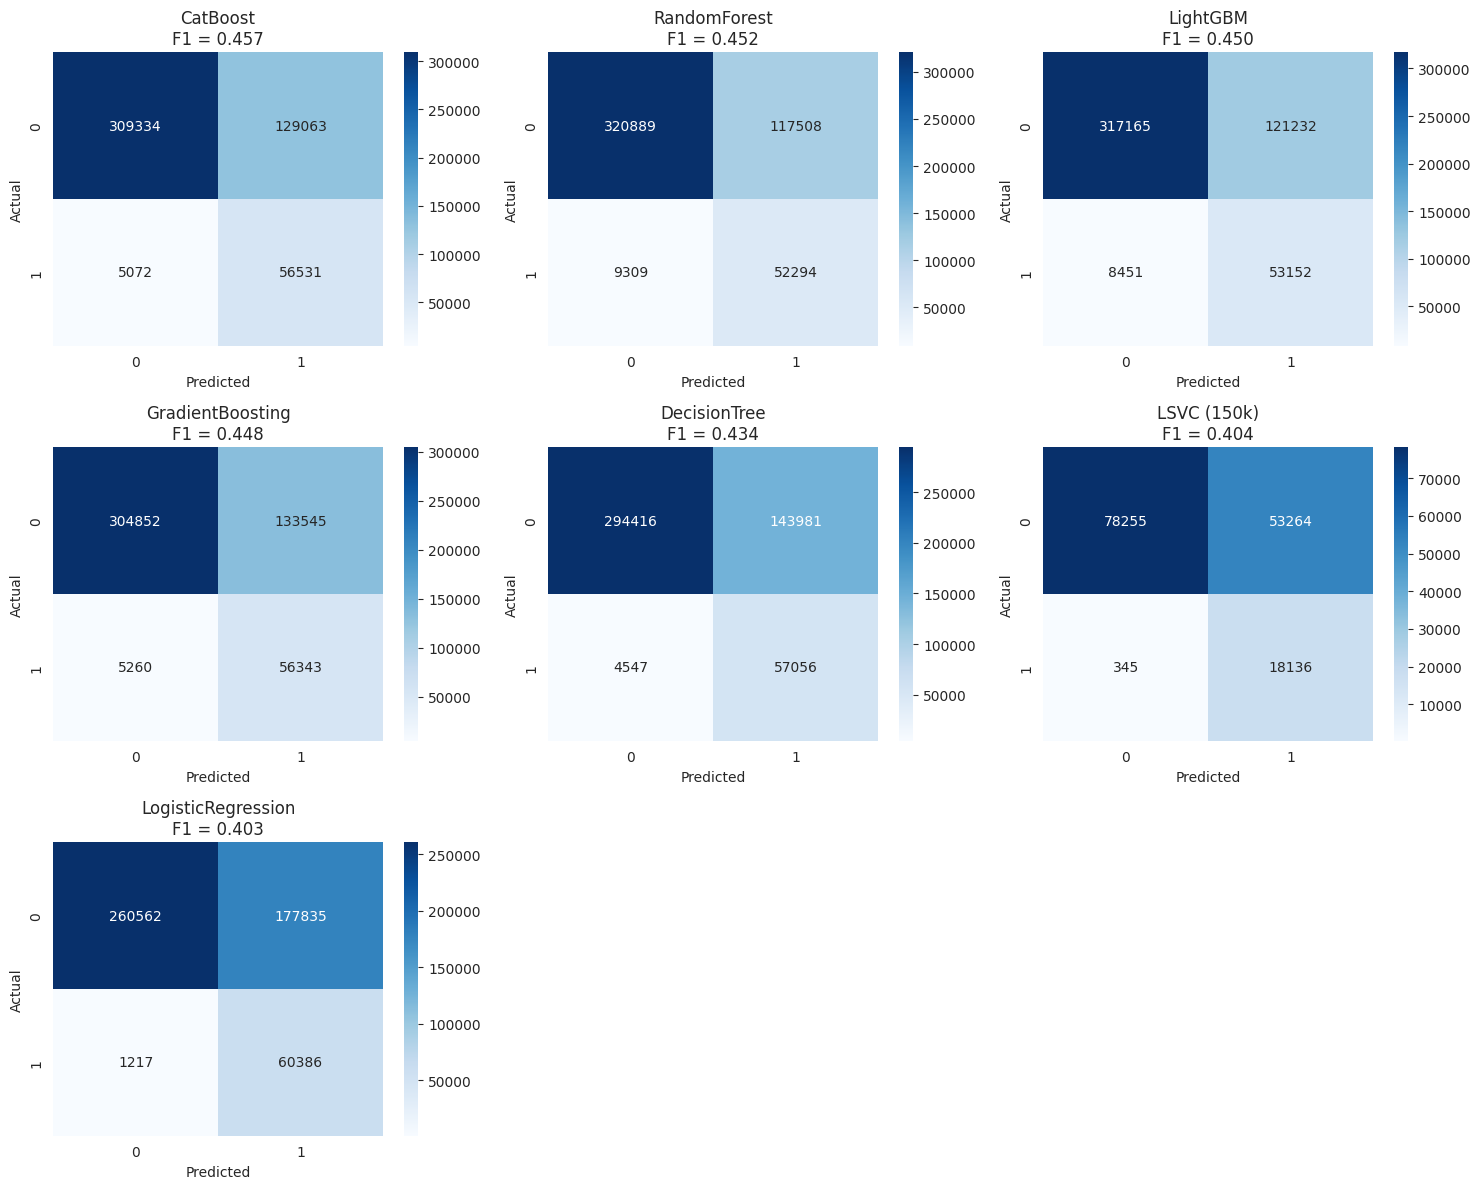

In [48]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='F1', ascending=False)

sorted_model_names = results_df['Model'].tolist()
sorted_conf_matrices = {name: conf_matrices[name] for name in sorted_model_names}

n_models = len(sorted_conf_matrices)
n_cols = 3
n_rows = math.ceil(n_models / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, (name, cm) in enumerate(sorted_conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    f1_val = results_df.loc[results_df['Model'] == name, 'F1'].values[0]
    axes[i].set_title(f'{name}\nF1 = {f1_val:.3f}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

for j in range(n_models, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**Вывод:**

Топ 3 моделей по целевой метрике F1:
- RandomForest
- LightGBM
- CatBoost

### Подбор порогов для топ-3 моделей по метрике F1

Оптимизация порога для RandomForest...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done 135 out of 135 | elapsed:    6.9s finished


RandomForest - Лучший порог: 0.580, F1: 0.4569
Оптимизация порога для LightGBM...
LightGBM - Лучший порог: 0.560, F1: 0.4593
Оптимизация порога для CatBoost...
CatBoost - Лучший порог: 0.700, F1: 0.4886


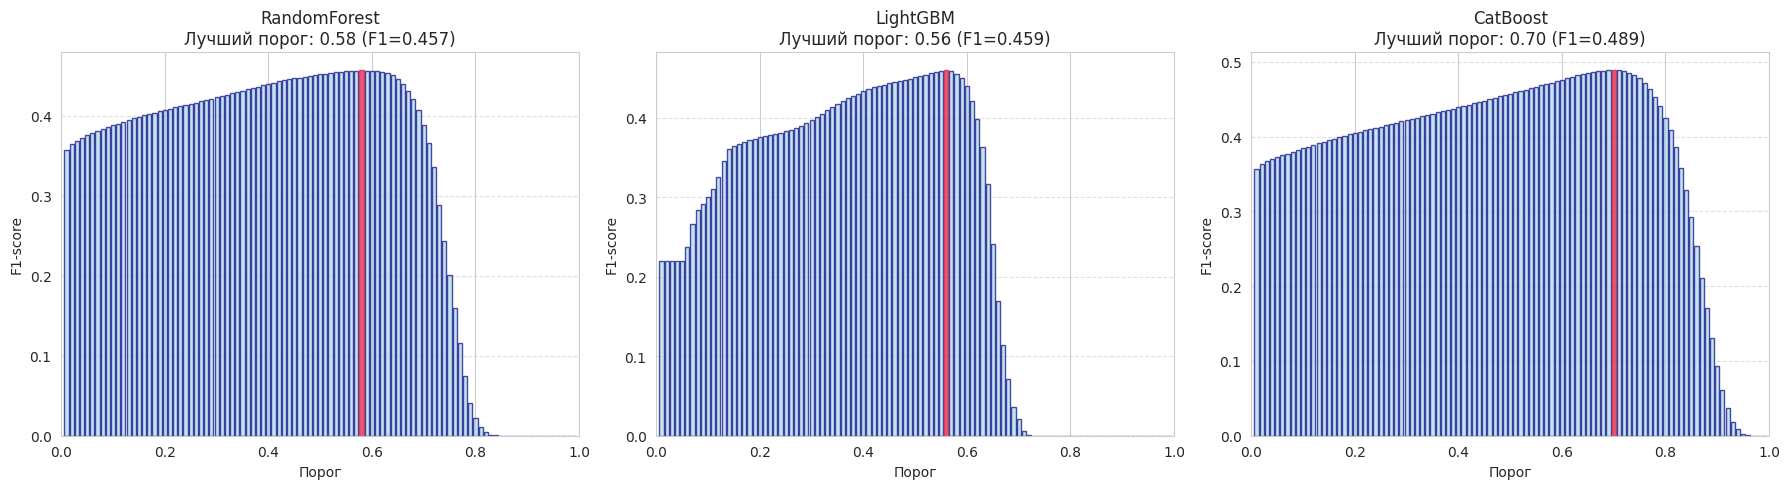

In [49]:
def find_best_threshold(pipeline, X, y, thresholds=None):
    if thresholds is None:
        thresholds = np.arange(0.01, 1.0, 0.01)

    y_proba = pipeline.predict_proba(X)[:, 1]
    f1_scores = []

    best_f1 = 0
    best_threshold = 0.5

    for th in thresholds:
        y_pred = (y_proba >= th).astype(int)
        f1 = f1_score(y, y_pred)
        f1_scores.append(f1)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = th

    return best_threshold, best_f1, y_proba, thresholds, f1_scores


print("Оптимизация порога для RandomForest...")
th_rf, f1_rf, proba_rf, thrs_rf, f1s_rf = find_best_threshold(rf_pipeline, X_test, y_test)
print(f"RandomForest - Лучший порог: {th_rf:.3f}, F1: {f1_rf:.4f}")

print("Оптимизация порога для LightGBM...")
th_lgbm, f1_lgbm, proba_lgbm, thrs_lgbm, f1s_lgbm = find_best_threshold(lgbm_pipeline, X_test, y_test)
print(f"LightGBM - Лучший порог: {th_lgbm:.3f}, F1: {f1_lgbm:.4f}")

print("Оптимизация порога для CatBoost...")
th_cb, f1_cb, proba_cb, thrs_cb, f1s_cb = find_best_threshold(cb_model, cb_X_test, cb_y_test)
print(f"CatBoost - Лучший порог: {th_cb:.3f}, F1: {f1_cb:.4f}")


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [
    ("RandomForest", thrs_rf, f1s_rf, th_rf, f1_rf),
    ("LightGBM", thrs_lgbm, f1s_lgbm, th_lgbm, f1_lgbm),
    ("CatBoost", thrs_cb, f1s_cb, th_cb, f1_cb)
]

for ax, (name, thresholds, f1_vals, best_th, best_f1) in zip(axes, models):
    bars = ax.bar(thresholds, f1_vals, width=0.008, color='lightblue', edgecolor='navy', alpha=0.7)

    best_idx = np.argmax(f1_vals)
    bars[best_idx].set_color('crimson')

    ax.set_title(f'{name}\nЛучший порог: {best_th:.2f} (F1={best_f1:.3f})')
    ax.set_xlabel('Порог')
    ax.set_ylabel('F1-score')
    ax.set_xlim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

**Вывод:**

Самый лучший показатель по метрике F1 - CatBoost с порогом 0.680 и максимальный F1 = 0.4711

### Ансамбль топ-3 моделей с soft voting (усреднение порога вероятности)

In [50]:
proba_ensemble = (proba_rf + proba_lgbm + proba_cb) / 3

thresholds = np.arange(0.01, 1.0, 0.01)
best_f1_ens = 0
best_th_ens = 0.5

for th in thresholds:
    y_pred_ens = (proba_ensemble >= th).astype(int)
    f1_ens = f1_score(y_test, y_pred_ens)
    if f1_ens > best_f1_ens:
        best_f1_ens = f1_ens
        best_th_ens = th

print(f"Лучший порог ансамбля: {best_th_ens:.3f}, F1: {best_f1_ens:.4f}")

Лучший порог ансамбля: 0.630, F1: 0.4794


**Вывод:**

Ансамбль ухудшил результат, потому что RandomForest и LightGBM значительно слабее CatBoost. При усреднении их менее уверенные и менее точные вероятности «размывают» высококачественные предсказания CatBoost, сдвигая распределение вероятностей к центру и снижая максимальную достижимую F1.

Поэтому логичнее использовать только CatBoost - он даёт лучшее качество, проще в эксплуатации и не «портится» вкладом менее эффективных моделей.

### CatBoost Optuna Best Model

In [51]:
df = pd.read_csv(FILE_PATH, index_col='id')

df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'No': 0, 'Yes': 1})
df['Vehicle_Age'] = df['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})

df['Region_Code'] = df['Region_Code'].astype('int64').astype(str)
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('int64').astype(str)

df_sample = df.sample(n=2_000_000, random_state=42)
X = df_sample.drop("Response", axis=1)
y = df_sample["Response"]

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=500_000, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    train_size=1_000_000,
    test_size=200_000,
    stratify=y_train_val,
    random_state=42
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Class balance in train: {y_train.value_counts(normalize=True)}")

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

cat_features = ['Region_Code', 'Policy_Sales_Channel']

Train: (1000000, 10), Val: (200000, 10), Test: (500000, 10)
Class balance in train: Response
0   0.88
1   0.12
Name: proportion, dtype: float64


In [52]:
artefact = get_model_file('catboost_optuna_best.pkl')
model = artefact['model']
best_th = artefact['threshold']

y_proba_test = model.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= best_th).astype(int)

metrics_cb = {
    'Model': 'CatBoost Best Model',
    'Precision': precision_score(y_test, y_pred_test),
    'Recall': recall_score(y_test, y_pred_test),
    'F1': f1_score(y_test, y_pred_test),
    'ROC-AUC': roc_auc_score(y_test, y_proba_test),
    'Time (sec)': artefact['optuna_time_sec']
}

print("Метрики CatBoost Best Model:")
print({k: v for k, v in metrics_cb.items() if k != 'Time (sec)'})

Метрики CatBoost Best Model:
{'Model': 'CatBoost Best Model', 'Precision': 0.36753814067298374, 'Recall': 0.7271117608836907, 'F1': 0.4882680832960632, 'ROC-AUC': 0.8782741955292611}


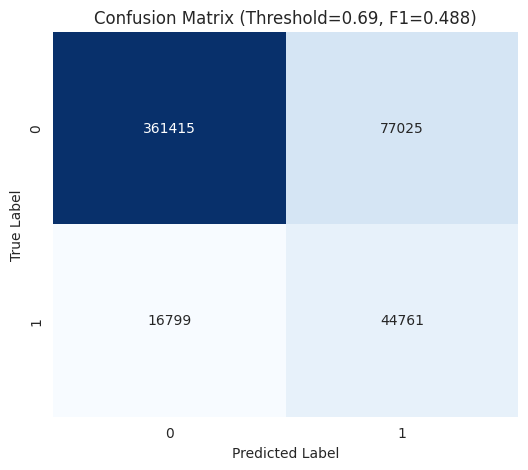

In [53]:
cm_cb = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_cb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (Threshold={best_th:.2f}, F1={metrics_cb['F1']:.3f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Feature importance CatBoost Optuna Best Model

                feature  importance
4    Previously_Insured       25.58
9               Vintage       17.53
1                   Age       14.13
7        Annual_Premium       12.34
8  Policy_Sales_Channel       11.54
6        Vehicle_Damage        7.79
3           Region_Code        7.17
0                Gender        2.04
5           Vehicle_Age        1.80
2       Driving_License        0.07


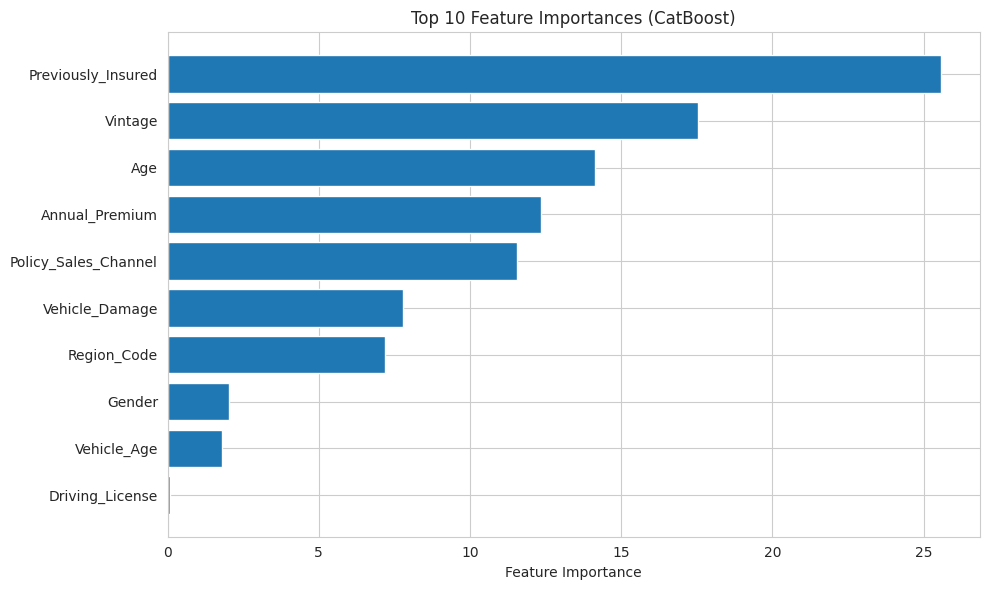

In [54]:
importances = model.get_feature_importance()
feature_names = X_train.columns

feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False)

print(feat_imp.head(10))

feat_imp.to_csv('catboost_best_feature_importances.csv', index=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'][:10][::-1], feat_imp['importance'][:10][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances (CatBoost)')
plt.tight_layout()
plt.show()

**Вывод:**

Все признаки имеют ненулевое значение важности, следовательно, оставляем все.

### CatBoost Optuna Best Model + feature engineering

In [55]:
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'No': 0, 'Yes': 1})
df['Vehicle_Age'] = df['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})

df['Region_Code'] = df['Region_Code'].astype('int64').astype(str)
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('int64').astype(str)

df_sample = df.sample(n=2_000_000, random_state=42)
X = df_sample.drop("Response", axis=1)
y = df_sample["Response"]

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=500_000, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    train_size=1_000_000,
    test_size=200_000,
    stratify=y_train_val,
    random_state=42
)

# Логарифм премии
X_train['Log_Annual_Premium'] = np.log1p(X_train['Annual_Premium'])
X_val['Log_Annual_Premium']   = np.log1p(X_val['Annual_Premium'])
X_test['Log_Annual_Premium']  = np.log1p(X_test['Annual_Premium'])

# Премия на возраст
X_train['Premium_per_Age'] = X_train['Annual_Premium'] / (X_train['Age'] + 1)
X_val['Premium_per_Age']   = X_val['Annual_Premium'] / (X_val['Age'] + 1)
X_test['Premium_per_Age']  = X_test['Annual_Premium'] / (X_test['Age'] + 1)

# Старое авто + ДТП
X_train['Old_Car_With_Damage'] = ((X_train['Vehicle_Age'] == 2) & (X_train['Vehicle_Damage'] == 1)).astype(int)
X_val['Old_Car_With_Damage']   = ((X_val['Vehicle_Age'] == 2) & (X_val['Vehicle_Damage'] == 1)).astype(int)
X_test['Old_Car_With_Damage']  = ((X_test['Vehicle_Age'] == 2) & (X_test['Vehicle_Damage'] == 1)).astype(int)

# Женщина + ДТП
X_train['Female_With_Damage'] = ((X_train['Gender'] == 0) & (X_train['Vehicle_Damage'] == 1)).astype(int)
X_val['Female_With_Damage']   = ((X_val['Gender'] == 0) & (X_val['Vehicle_Damage'] == 1)).astype(int)
X_test['Female_With_Damage']  = ((X_test['Gender'] == 0) & (X_test['Vehicle_Damage'] == 1)).astype(int)

channel_new_rate = X_train.groupby('Policy_Sales_Channel')['Previously_Insured'].apply(lambda x: (x == 0).mean())
global_new_rate = (X_train['Previously_Insured'] == 0).mean()

X_train['New_Customer_Rate_By_Channel'] = X_train['Policy_Sales_Channel'].map(channel_new_rate).fillna(global_new_rate)
X_val['New_Customer_Rate_By_Channel']   = X_val['Policy_Sales_Channel'].map(channel_new_rate).fillna(global_new_rate)
X_test['New_Customer_Rate_By_Channel']  = X_test['Policy_Sales_Channel'].map(channel_new_rate).fillna(global_new_rate)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Class balance in train: {y_train.value_counts(normalize=True)}")

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

cat_features = ['Region_Code', 'Policy_Sales_Channel']

Train: (1000000, 15), Val: (200000, 15), Test: (500000, 15)
Class balance in train: Response
0   0.88
1   0.12
Name: proportion, dtype: float64


In [56]:
artefact = get_model_file('catboost_optuna_best_fe.pkl')
model = artefact['model']
best_th = artefact['threshold']

y_proba_test = model.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= best_th).astype(int)

metrics_cb = {
    'Model': 'CatBoost Best Model',
    'Precision': precision_score(y_test, y_pred_test),
    'Recall': recall_score(y_test, y_pred_test),
    'F1': f1_score(y_test, y_pred_test),
    'ROC-AUC': roc_auc_score(y_test, y_proba_test),
    'Time (sec)': artefact['optuna_time_sec']
}

print("Метрики CatBoost Best Model:")
print({k: v for k, v in metrics_cb.items() if k != 'Time (sec)'})

Метрики CatBoost Best Model:
{'Model': 'CatBoost Best Model', 'Precision': 0.5113562621674238, 'Recall': 0.012800519818063677, 'F1': 0.02497583239568311, 'ROC-AUC': 0.8453039409461296}


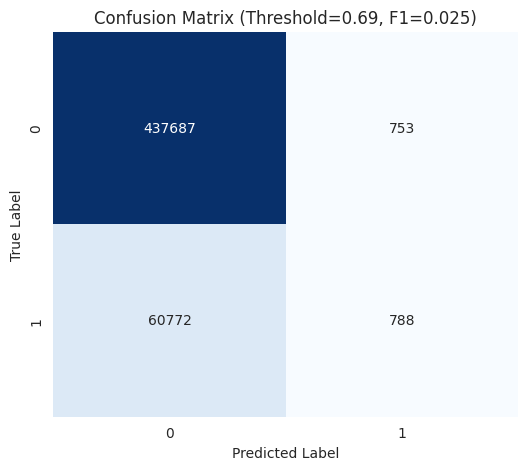

In [57]:
cm_cb = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_cb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (Threshold={best_th:.2f}, F1={metrics_cb['F1']:.3f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

                         feature  importance
4             Previously_Insured       28.37
9                        Vintage       17.60
1                            Age        9.94
6                 Vehicle_Damage        8.81
14  New_Customer_Rate_By_Channel        7.45
3                    Region_Code        6.87
7                 Annual_Premium        6.25
11               Premium_per_Age        6.21
8           Policy_Sales_Channel        2.89
10            Log_Annual_Premium        2.65
0                         Gender        1.57
5                    Vehicle_Age        0.83
13            Female_With_Damage        0.40
12           Old_Car_With_Damage        0.10
2                Driving_License        0.05


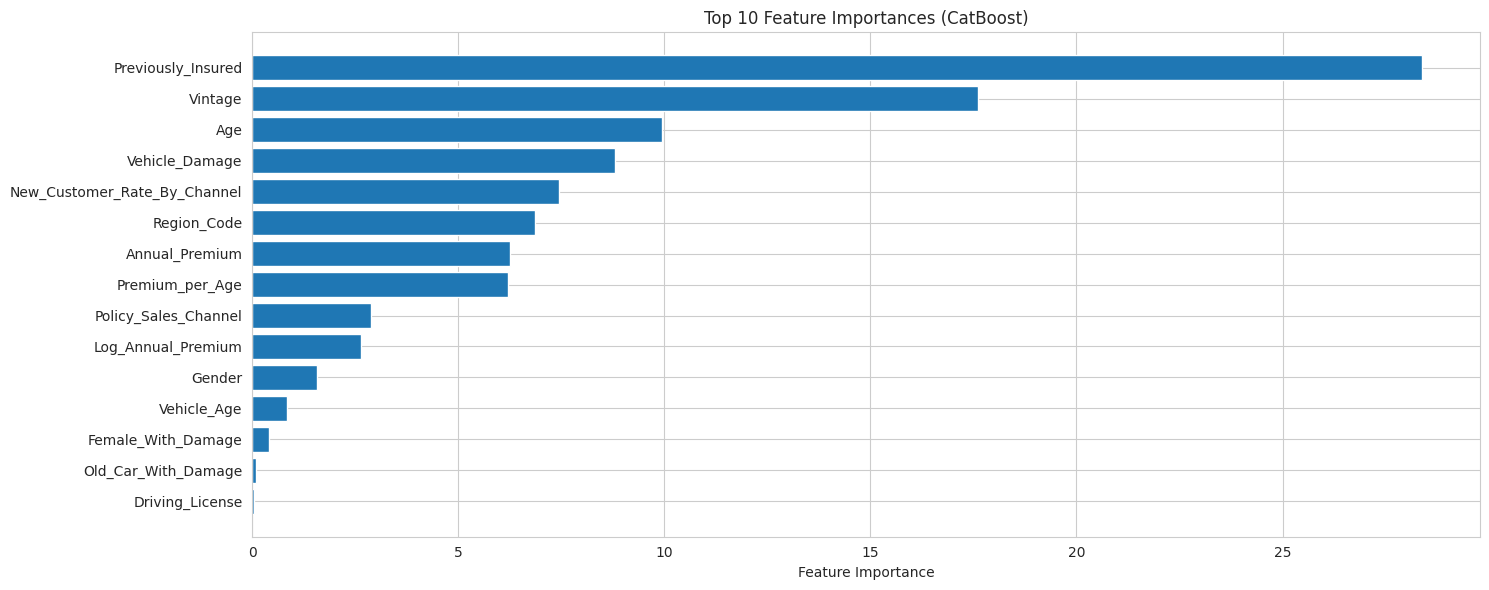

In [58]:
importances = model.get_feature_importance()
feature_names = X_train.columns

feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False)

print(feat_imp.head(15))

plt.figure(figsize=(15, 6))
plt.barh(feat_imp['feature'][:15][::-1], feat_imp['importance'][:15][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances (CatBoost)')
plt.tight_layout()
plt.show()

**Вывод:**

Новые фичи не вносят вклад в улучшение метрик модели. В их использовании нет необходимости.

In [59]:
import sklearn
print(sklearn.__version__)

1.7.2
